# Haciendo un Clasificador en Segundos

A continuación dejaremos como bonus la forma en la que se puede utilizar un modelo de Red Neuronal pre-entrenado en conjuntos de imágenes naturales, y utilizarlo para clasificar en otro problema. Se llama hacer *fine tuning* para un *downstream task*. 

Utilizaremos un ejemplo de clasificación de Google que se encuentra en https://www.tensorflow.org/tutorials/images/transfer_learning


<table class="tfo-notebook-buttons" align="center">

  <td>
    <a target="_blank" href="https://colab.research.google.com/github/juancop/URDeepLearning/blob/main/ComputerVision/Fine%20Tuning%20an%20Image%20Model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/juancop/URDeepLearning/blob/main/ComputerVision/Fine%20Tuning%20an%20Image%20Model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  
</table>

Si estás en colab corre la siguiente celda:

In [ ]:
!git clone https://github.com/juancop/URDeepLearning && pip install -r URDeepLearning/requirements.txt

## Contexto

El Transfer Learning y el Fine Tuning son procedimientos que permiten utilizar una Red Neuronal Pre-Entrenada para aprovechar sus pesos en un nuevo modelo, sin tener que comenzar desde cero. 

En este ejercicio utilizaremos los pesos de MobileNet entrenados con ImageNet para entrenar un clasificador de perros y gatos. Sin embargo, pueden utilizarse otras arquitecturas de modelos y pesos iniciales. 

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

## Descarga de Información

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


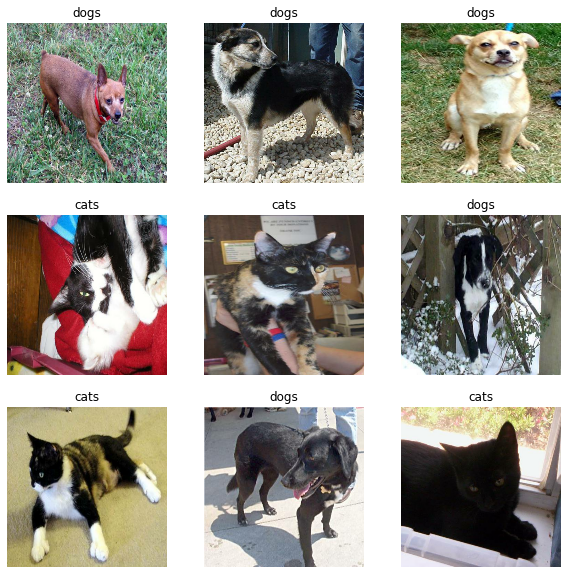

In [5]:
class_names = train_dataset.class_names#

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])   
        plt.axis("off")

A continuación se hace la división del data set de validación en prueba y validación. 

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Pre-Procesamiento de Imágenes

El pre-procesamiento de imágenes se debe llevar acabo en dos etapas: 

1. **Data Augmentation** Para generar nuevas imágenes en el conjunto de datos. Es útil cuando hay pocos datos, y ayuda a que el modelo generalice mejor.

2. **Rescaling & Reshaping** Ajustar las imágenes para que cumplan con el tipo de dato que espera el modelo



In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Ejemplos de imágenes

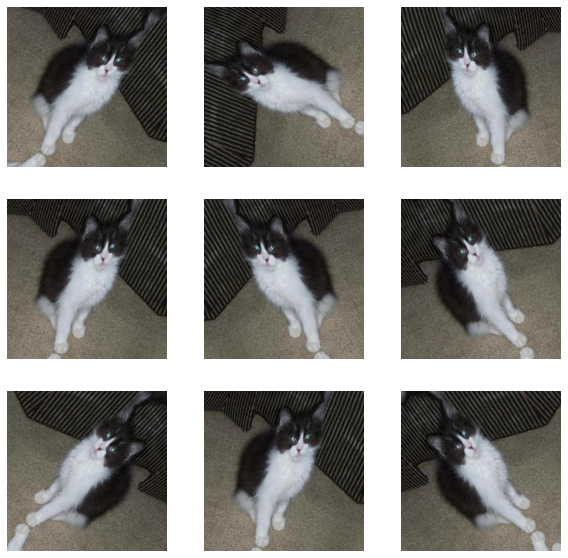

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Selección del Modelo Base

Utilizamos como modelo base MobileNet V2, preentrenado en ImageNet. Este modelo espera que los datos de entrada sean imágenes de tres canales de dimensión (160, 160, 3), y los píxeles vayan en intensidad de -1 a 1. 

Al cargar el modelo dejaremos por fuera la capa de clasificación, de forma que únicamente nos quedamos con MobileNet como extractor de características. 

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
# Instanciamiento del Modelo
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # Quita capa de clasificación
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape) # Bloque de características extraídas 5x5x1280

(32, 5, 5, 1280)


Nuestro objetivo es entrenar una capa de clasificación que aproveche los features que aprendió de ImageNet, por lo que no queremos dañar el modelo con nuestros (pocos) datos.

In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

## ¡Capa de Clasificación!

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # Pasamos de 55x1280 a 1x1280
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Definición del Modelo Completo

Aquí buscamos unir nuestros inputs, con el extractor de características `base_model` y una capa de clasificación 

In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x) # Podríamos añadir más capas
outputs = tf.keras.layers.Dense(1)(x) # Probabilidad de que sea perro o gato
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [20]:
EPOCHS = 10
loss, accuracy = model.evaluate(validation_dataset) # Desempeño sin entrenar (pesos aleatorios)

26/26 [==============================] - 4s 45ms/step - loss: 0.7698 - accuracy: 0.5210


In [21]:
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))

initial loss: 0.77
initial accuracy: 0.52


### Transfer Learning en Acción

A continuación se realiza el entrenamiento del modelo partiendo de los pesos del extractor. Realmente se está entrenando la capa FC que conecta los features a la Dense(1). 

In [22]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 7s 64ms/step - loss: 0.6931 - accuracy: 0.5815 - val_loss: 0.5279 - val_accuracy: 0.6819
Epoch 2/10
63/63 [==============================] - 4s 59ms/step - loss: 0.5310 - accuracy: 0.7030 - val_loss: 0.3886 - val_accuracy: 0.7933
Epoch 3/10
63/63 [==============================] - 4s 60ms/step - loss: 0.4236 - accuracy: 0.7885 - val_loss: 0.3059 - val_accuracy: 0.8564
Epoch 4/10
63/63 [==============================] - 4s 60ms/step - loss: 0.3512 - accuracy: 0.8355 - val_loss: 0.2528 - val_accuracy: 0.8824
Epoch 5/10
63/63 [==============================] - 4s 59ms/step - loss: 0.3135 - accuracy: 0.8600 - val_loss: 0.2108 - val_accuracy: 0.9171
Epoch 6/10
63/63 [==============================] - 4s 60ms/step - loss: 0.2787 - accuracy: 0.8750 - val_loss: 0.1881 - val_accuracy: 0.9233
Epoch 7/10
63/63 [==============================] - 4s 59ms/step - loss: 0.2638 - accuracy: 0.8865 - val_loss: 0.1705 - val_accuracy: 0.9332
Epoch 8/10
63

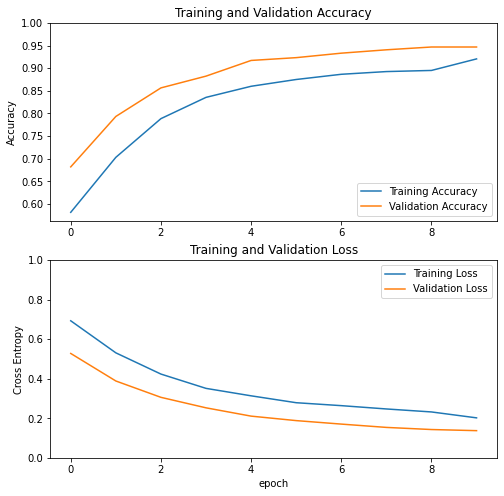

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show() 

In [24]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test accuracy :', test_accuracy)

6/6 [==============================] - 1s 46ms/step - loss: 0.1146 - accuracy: 0.9635
Test accuracy : 0.9635416865348816


# Fine Tuning

Hasta este punto se hizo el entrenamiento de la FC para la clasificación, dejando intacto el extractor de características. Una vez aprendido el clasificador, puede *fine tunearse* el extractor, permitiendo generar características más adecuadas para el conjunto de datos. 

Las capas más altas de la red aprenden características mucho más específicas (y valiosas) que las primeras capas del modelo. ¡Vamos a entrenar esas!

In [25]:
base_model.trainable = True

In [26]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


MobileNet cuenta con 155 capas ocultas (nuestro feature extractor). Vamos a Finetunear las últimas 55 capas del modelo, por lo que debemos mantener congeladas las primeras 100. De esta forma las features básicas que aprendió el modelo quedan intactas.

In [27]:
for layer in base_model.layers[:100]:
    layer.trainable = False

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [30]:
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS =  EPOCHS + FINE_TUNE_EPOCHS

history_fine = model.fit(train_dataset,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 12s 80ms/step - loss: 0.1503 - accuracy: 0.9360 - val_loss: 0.0532 - val_accuracy: 0.9814
Epoch 11/20
63/63 [==============================] - 4s 67ms/step - loss: 0.1216 - accuracy: 0.9510 - val_loss: 0.0734 - val_accuracy: 0.9814
Epoch 12/20
63/63 [==============================] - 4s 66ms/step - loss: 0.1156 - accuracy: 0.9555 - val_loss: 0.0540 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 4s 67ms/step - loss: 0.1074 - accuracy: 0.9590 - val_loss: 0.0547 - val_accuracy: 0.9777
Epoch 14/20
63/63 [==============================] - 4s 67ms/step - loss: 0.0932 - accuracy: 0.9625 - val_loss: 0.0429 - val_accuracy: 0.9802
Epoch 15/20
63/63 [==============================] - 8s 117ms/step - loss: 0.0791 - accuracy: 0.9690 - val_loss: 0.0431 - val_accuracy: 0.9889
Epoch 16/20
63/63 [==============================] - 5s 75ms/step - loss: 0.0851 - accuracy: 0.9655 - val_loss: 0.0424 - val_accuracy: 0.9802
Epoc

In [31]:
acc.extend(history_fine.history['accuracy'])
val_acc.extend(history_fine.history['val_accuracy'])

loss.extend(history_fine.history['loss'])
val_loss.extend(history_fine.history['val_loss'])

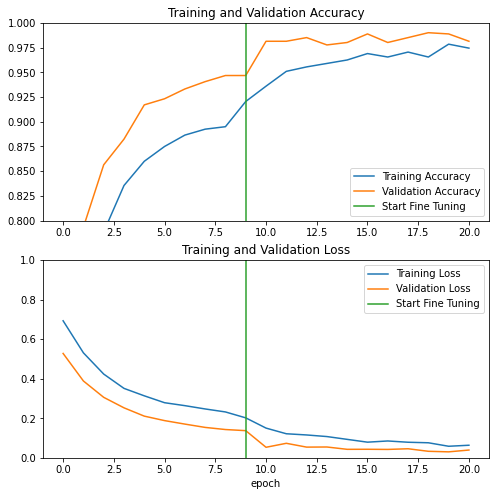

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 43ms/step - loss: 0.0232 - accuracy: 0.9896
Test accuracy : 0.9895833134651184




```
# MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.
```

